In [ ]:
!pip install -r requirements

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import datetime as dt 
from copy import deepcopy

import nn.model

### Data

In [2]:
def generate_data(n_classes):
    data = nn.util.one_hot(np.arange(n_classes), n_classes)
    return data

In [3]:
x = y = generate_data(n_classes=8)
x

array([[1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1]])

### Model

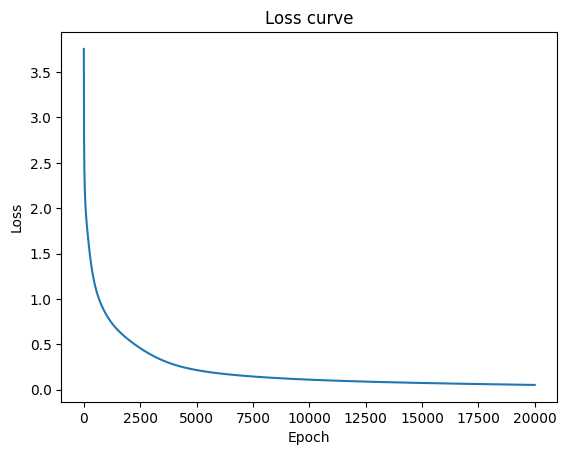

In [5]:
model = nn.model.Model([
    nn.layer.Layer(8, 3, nn.activation.sigmoid, std=1),
    nn.layer.Layer(3, 8, std=1),
])

# Notice that a single layer of shape (8, 8) without activation can solve this problem (almost) perfectly.
# The assignment didn't say anything about the activation function. If we use no activation function,
# the two linear layers collapse into a single 8-to-8 linear transform, corresponding to the identity matrix.
# But I assume we are supposed to use sigmoid.

model.fit(
    x, 
    y, 
    n_epochs=20_000, 
    batch_size=8, # each parameter update takes into account all classes!
    lr=0.1, 
    # reg_coeff=0.01,
    loss_fn=nn.loss.cross_entropy_from_logits,
    verbose=False,
)

# worked well: 
# n_epochs=10_000, lr=0.1, reg_coeff=0.01 (and generally reg_coeff=lr/10 or even lr/100) 

plt.title("Loss curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(model.history["epoch_loss"])
# plt.savefig("epochs10000_batchsize8_lr01.png", dpi=200)

In [6]:
# Prediction 
nn.util.softmax(model(x)).round(0)

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.]])

In [7]:
def plot_latent_space(a, title=None, save=False):
    # a: activations = latent space vectors
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    if title is not None:
        plt.title(title)
    ax.scatter(a[:,0], a[:,1], a[:,2], c="tab:blue", s=50, depthshade=True)
    ax.set_xlabel(r"$a_1$")
    ax.set_ylabel(r"$a_2$")
    ax.set_zlabel(r"$a_3$")
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.1)
    ax.set_zlim(-0.1, 1.1)
    if save:
        plt.savefig(f"{dt.datetime.now()}.png", dpi=200)

#### Multiple random initializations plotted as median and 10–90 percentile band (or range band) 

In [ ]:
# The network is initialized randomly using Gaussian noise (default std=0.01, but it can be passed to the layer)
# -> luck how well it's initialized (i.e. which minimum it will end up in)

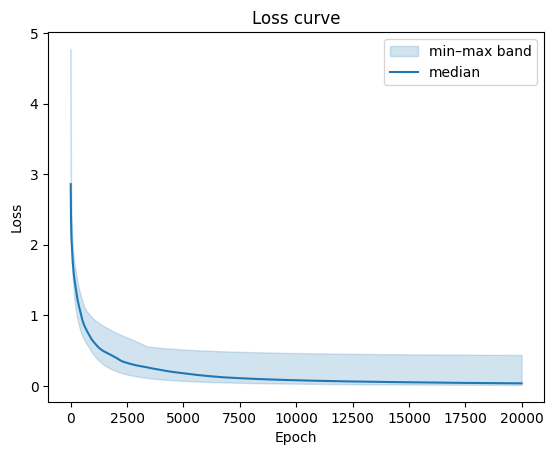

In [8]:
# Keeping track of best and worst model 
lowest_final_loss = np.inf
highest_final_loss = -np.inf
best_model = None
worst_model = None

history = []
for r in range(50):
    np.random.seed(r)
    model = nn.model.Model([
        nn.layer.Layer(8, 3, nn.activation.sigmoid, std=1),
        nn.layer.Layer(3, 8, std=1),
    ])
    model.fit(
        x, 
        y, 
        n_epochs=20_000, 
        batch_size=8, 
        lr=0.1, 
        # reg_coeff=0.01,
        loss_fn=nn.loss.cross_entropy_from_logits,
        verbose=False
    )
    history.append(model.history["epoch_loss"])

    # Keeping track of best and worst model 
    final_loss = model.history["epoch_loss"][-1]
    if final_loss < lowest_final_loss:
        lowest_final_loss = final_loss
        best_model = deepcopy(model)
    elif final_loss > highest_final_loss:
        highest_final_loss = final_loss
        worst_model = deepcopy(model)

history = np.array(history)
n_epochs = history.shape[1]
median = np.median(history, axis=0)
# p10 = np.percentile(history, 5, axis=0)
# p90 = np.percentile(history, 95, axis=0)

plt.title("Loss curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
# plt.fill_between(range(n_epochs), p10, p90, color='tab:blue', alpha=0.2, label="10–90 percentile band")
plt.fill_between(range(n_epochs), history.min(axis=0), history.max(axis=0), color='tab:blue', alpha=0.2, label="min–max band")
plt.plot(median, label="median")
plt.legend()
# plt.savefig("epochs10000_batchsize8_lr01_band.png", dpi=200)

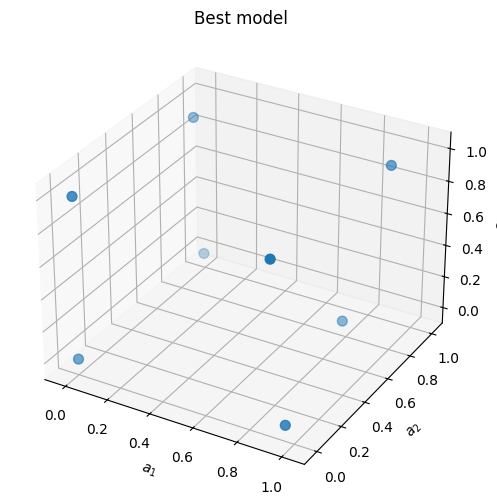

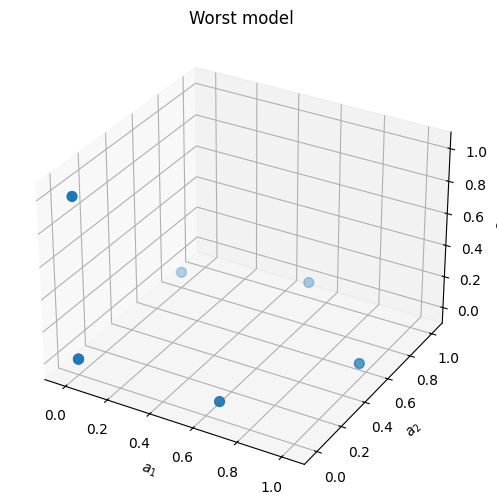

In [9]:
# Let's see what the best and worst models' latent space looks like 

plot_latent_space(best_model.layers[0](x), "Best model") 
# perfect cube (or close to it, but even then there is no collapse)

plot_latent_space(worst_model.layers[0](x), "Worst model")
# unsurprisingly, many inputs collapse onto the same corners of the cube

#### Experiment 1: Learning rate

/Users/janikeuskirchen/Code/Maastricht/acml-assignment-1/nn/activation/sigmoid.py:7: RuntimeWarning: overflow encountered in exp
  return np.divide(1, 1+np.exp(-x))


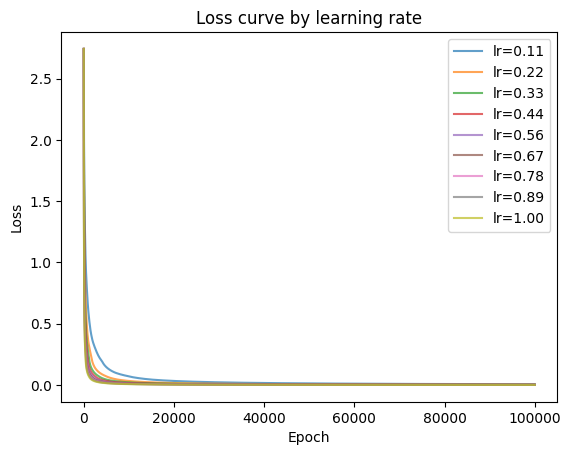

In [10]:
plt.title("Loss curve by learning rate")
plt.xlabel("Epoch")
plt.ylabel("Loss")

n_runs = 10

# Same initializations for all runs
model_templates = {}
for i in range(n_runs):
    model_templates[i] = nn.model.Model([
        nn.layer.Layer(8, 3, nn.activation.sigmoid, std=1),
        nn.layer.Layer(3, 8, std=1),
    ])

for lr in np.linspace(0, 1.0, 10):
    if lr > 0:
        histories = []
        for i in range(n_runs):
            model = deepcopy(model_templates[i])
            model.fit(
                x, 
                y, 
                n_epochs=100_000, 
                batch_size=8, 
                lr=lr, 
                # reg_coeff=0.01,
                loss_fn=nn.loss.cross_entropy_from_logits,
                verbose=False
            )
            histories.append(model.history["epoch_loss"])
        plt.plot(np.median(histories, axis=0), alpha=0.7, label=f"lr={lr:.2f}")
        """
        plt.fill_between(
            len(histories[0]), 
            np.min(histories, axis=0), 
            np.max(histories, axis=0), 
            alpha=0.2, color="tab:blue") # label
        """

plt.legend();
# plt.savefig("runs_by_lr_.png", dpi=200)

#### Experiment 2: Regularization coefficient

best $\lambda$ = 0.015
worst $\lambda$ = 0.15


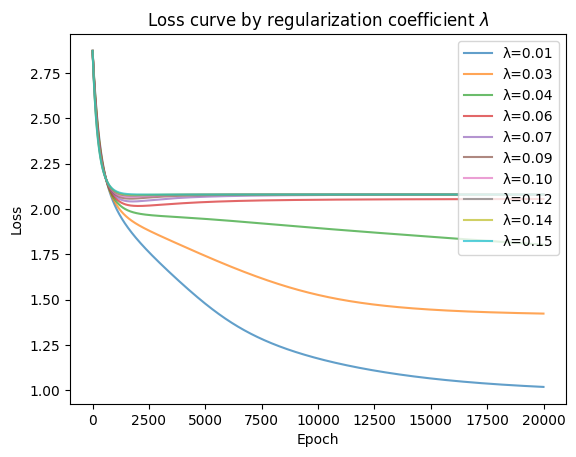

In [11]:
# Keeping track of best and worst model 
lowest_final_loss = np.inf
highest_final_loss = -np.inf
_best_model = None
_worst_model = None
best_reg_coeff = None 
worst_reg_coeff = None 

plt.title(r"Loss curve by regularization coefficient $\lambda$")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Same initialization for all runs 
model_template = nn.model.Model([
    nn.layer.Layer(8, 3, nn.activation.sigmoid, std=1),
    nn.layer.Layer(3, 8, std=1),
])

for reg_coeff in np.linspace(0, 0.15, 11):
    if reg_coeff > 0:
        model = deepcopy(model_template)
        model.fit(
            x, 
            y, 
            n_epochs=20_000, 
            batch_size=8, 
            lr=0.01, 
            reg_coeff=reg_coeff,
            loss_fn=nn.loss.cross_entropy_from_logits,
            verbose=False
        )

        # Importatnly, the loss in model.history doesn't actually include the regularization term!
        # since that is done in the gradient calculation directly

        plt.plot(model.history["epoch_loss"], alpha=0.7, label=f"λ={reg_coeff:.2f}")
        
        # Keeping track of best and worst model:
        final_loss = model.history["epoch_loss"][-1]
        if final_loss < lowest_final_loss:
            lowest_final_loss = final_loss
            _best_model = deepcopy(model)
            best_reg_coeff = reg_coeff
        elif final_loss > highest_final_loss:
            highest_final_loss = final_loss
            _worst_model = deepcopy(model)
            worst_reg_coeff = reg_coeff

plt.legend();
# plt.savefig("runs_by_reg_coeff.png", dpi=200)

print(r"best $\lambda$ =", best_reg_coeff)
print(r"worst $\lambda$ =", worst_reg_coeff)

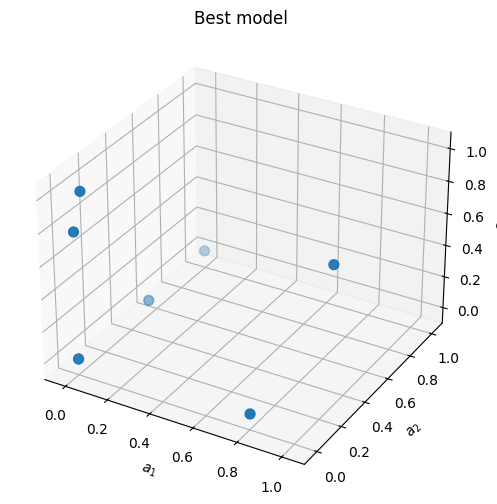

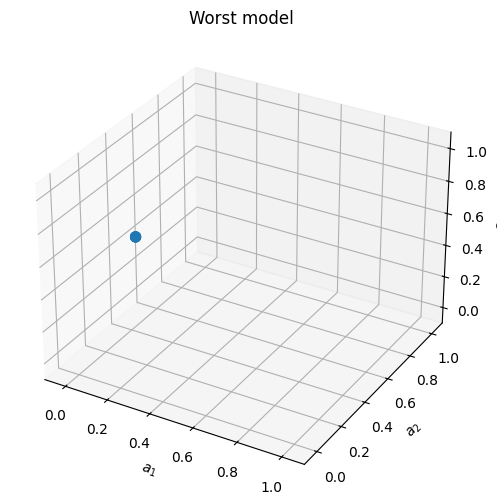

In [12]:
plot_latent_space(_best_model.layers[0](x), "Best model") 
plot_latent_space(_worst_model.layers[0](x), "Worst model")

#### Experiment 3: Cross entropy vs. mean squared error

In [13]:
def run_loss_comparison(n_trials=10, n_epochs=20000, lr=0.1, batch_size=8):
    ce_histories = []
    mse_histories = []
    ce_accs = []
    mse_accs = []
    
    # trails with different random initializations for each loss function
    for i in range(n_trials):
        # Cross-Entropy Model
        model_ce = nn.model.Model([
            nn.layer.Layer(8, 3, nn.activation.sigmoid),
            nn.layer.Layer(3, 8),
        ])
        
        # MSE Model 
        model_mse = nn.model.Model([
            nn.layer.Layer(8, 3, nn.activation.sigmoid),
            nn.layer.Layer(3, 8),
        ])
        
        # train both models with same initialization
        np.random.seed(i)
        model_ce.fit(x, y, n_epochs=n_epochs, batch_size=batch_size, 
                    lr=lr, loss_fn=nn.loss.cross_entropy_from_logits, verbose=False)
        
        np.random.seed(i)
        model_mse.fit(x, y, n_epochs=n_epochs, batch_size=batch_size,
                     lr=lr, loss_fn=nn.loss.mse, verbose=False)
        
        # store loss histories: append the epoch_loss list for each model
        ce_histories.append(model_ce.history["epoch_loss"])
        mse_histories.append(model_mse.history["epoch_loss"])
        
        # compute final accuracy (softmax - argmax) Use nn.util.accuracy if available, otherwise manual
        # Convert final outputs logits or linear outputs,  to probabilities via softmax
        # temperature=0.1 makes the softmax sharper more one hot alike
        preds_ce = nn.util.softmax(model_ce(x), temperature=0.1)
        preds_mse = nn.util.softmax(model_mse(x), temperature=0.1)

        try:
            #  an accuracy helper in nn.util.accuracy
            ce_acc = nn.util.accuracy(y, preds_ce)
            mse_acc = nn.util.accuracy(y, preds_mse)
        except Exception:
            ce_acc = (np.argmax(preds_ce, axis=1) == np.argmax(y, axis=1)).mean()
            mse_acc = (np.argmax(preds_mse, axis=1) == np.argmax(y, axis=1)).mean()

        ce_accs.append(ce_acc)
        mse_accs.append(mse_acc)

    return np.array(ce_histories), np.array(mse_histories), np.array(ce_accs), np.array(mse_accs)

/var/folders/bf/xywc__0916l4xwlx8f59k5w40000gn/T/ipykernel_12769/696956051.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([ce_hist[:,-1], mse_hist[:,-1]], labels=['Cross-Entropy', 'MSE'])


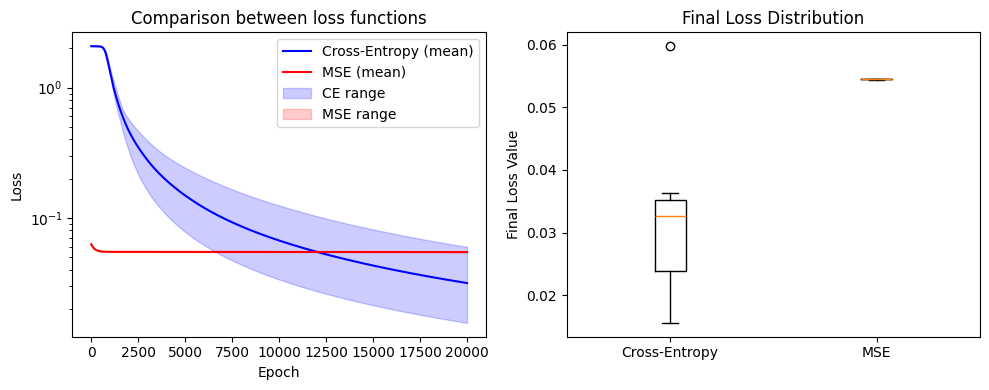

/var/folders/bf/xywc__0916l4xwlx8f59k5w40000gn/T/ipykernel_12769/696956051.py:39: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([ce_accs, mse_accs], labels=['Cross-Entropy', 'MSE'])


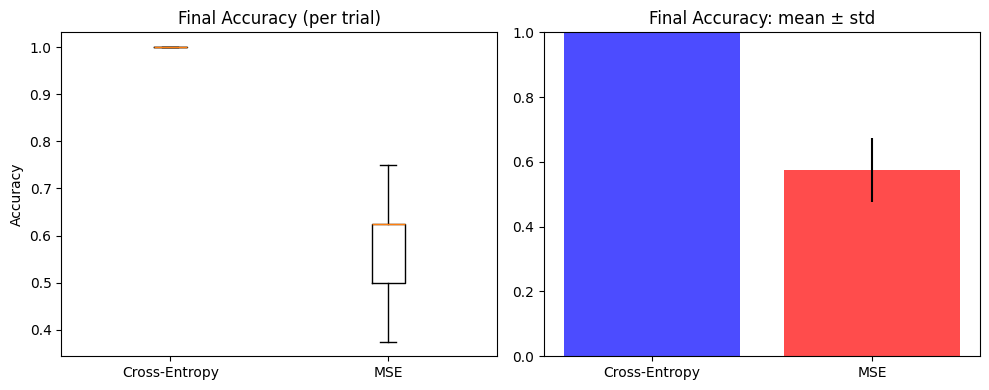

Cross-Entropy final accuracy mean: 1.0000  std: 0.0000
MSE final accuracy mean:           0.5750  std: 0.1000


In [14]:
# Run comparison visualization
ce_hist, mse_hist, ce_accs, mse_accs = run_loss_comparison(n_trials=10)

# plot hight and width
plt.figure(figsize=(10, 4))

# Loss curves
plt.subplot(121)
plt.title("Comparison between loss functions")
plt.plot(ce_hist.mean(axis=0), label='Cross-Entropy (mean)', color='blue')
plt.plot(mse_hist.mean(axis=0), label='MSE (mean)', color='red')
plt.fill_between(range(len(ce_hist[0])), 
                 ce_hist.min(axis=0), ce_hist.max(axis=0), 
                 alpha=0.2, color='blue', label='CE range')
plt.fill_between(range(len(mse_hist[0])), 
                 mse_hist.min(axis=0), mse_hist.max(axis=0), 
                 alpha=0.2, color='red', label='MSE range')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.yscale('log')

# final loss distribution
# boxplot of final losses, the bigger the better
# the size of the box shows variability across trials, the median line shows typical final loss 
plt.subplot(122)
plt.title("Final Loss Distribution")
plt.boxplot([ce_hist[:,-1], mse_hist[:,-1]], labels=['Cross-Entropy', 'MSE'])
plt.ylabel('Final Loss Value')

plt.tight_layout()
plt.show()


# Plot accuracy comparisons
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Final Accuracy (per trial)")
plt.boxplot([ce_accs, mse_accs], labels=['Cross-Entropy', 'MSE'])
plt.ylabel("Accuracy")

plt.subplot(1,2,2)
plt.title("Final Accuracy: mean ± std")
means = [ce_accs.mean(), mse_accs.mean()]
stds = [ce_accs.std(), mse_accs.std()]
plt.bar(['Cross-Entropy','MSE'], means, yerr=stds, color=['blue','red'], alpha=0.7)
plt.ylim(0,1)
plt.tight_layout()
plt.show()

# Print numeric summary
print(f"Cross-Entropy final accuracy mean: {ce_accs.mean():.4f}  std: {ce_accs.std():.4f}")
print(f"MSE final accuracy mean:           {mse_accs.mean():.4f}  std: {mse_accs.std():.4f}")

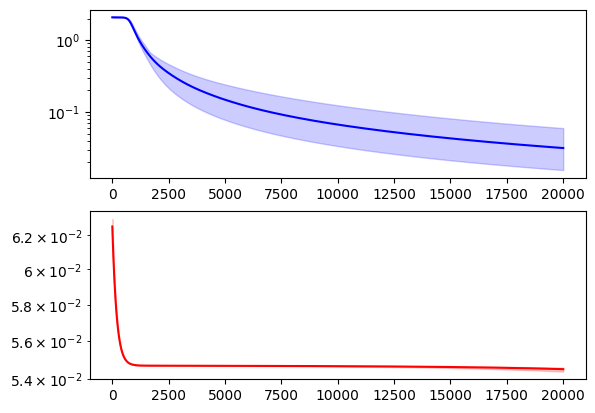

In [15]:
# Perhaps put CE and MSE loss curves in two separate plots, because they're on different scales? 
# It still shows that MSE very quickly reaches a plateau (and the accuracy plot confirms that it plateaus
# at a pretty bad solution)

fig, axes = plt.subplots(nrows=2)

axes[0].plot(ce_hist.mean(axis=0), label='Cross-Entropy (mean)', color='blue')
axes[0].fill_between(range(len(ce_hist[0])), 
                 ce_hist.min(axis=0), ce_hist.max(axis=0), 
                 alpha=0.2, color='blue', label='CE range')
axes[0].set_yscale('log')

axes[1].plot(mse_hist.mean(axis=0), label='MSE (mean)', color='red')
axes[1].fill_between(range(len(mse_hist[0])), 
                 mse_hist.min(axis=0), mse_hist.max(axis=0), 
                 alpha=0.2, color='red', label='MSE range')
axes[1].set_yscale('log')

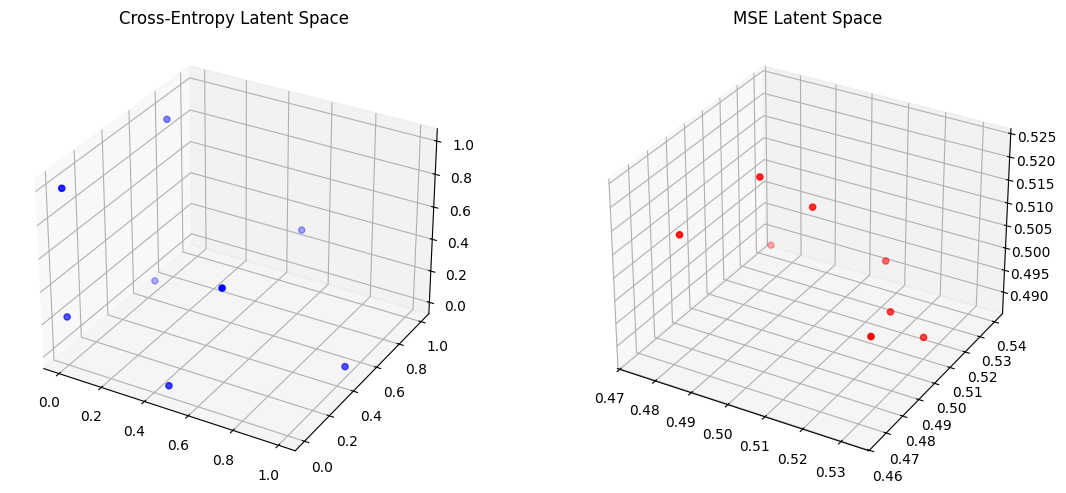

In [16]:
# Compare latent space representations
def plot_latent_comparison(ce_model, mse_model):
    fig = plt.figure(figsize=(12, 5))
    
    # CE latent space
    ax1 = fig.add_subplot(121, projection='3d')
    a_ce = ce_model.layers[0](x)
    ax1.scatter(a_ce[:,0], a_ce[:,1], a_ce[:,2], c="blue")
    ax1.set_title("Cross-Entropy Latent Space")
    
    # MSE latent space
    ax2 = fig.add_subplot(122, projection='3d')
    a_mse = mse_model.layers[0](x)
    ax2.scatter(a_mse[:,0], a_mse[:,1], a_mse[:,2], c="red")
    ax2.set_title("MSE Latent Space")
    
    plt.tight_layout()
    plt.show()

# Get models with best final loss
best_ce_idx = ce_hist[:,-1].argmin()
best_mse_idx = mse_hist[:,-1].argmin()

np.random.seed(best_ce_idx)
best_ce_model = nn.model.Model([
    nn.layer.Layer(8, 3, nn.activation.sigmoid),
    nn.layer.Layer(3, 8),
])
best_ce_model.fit(x, y, n_epochs=20_000, batch_size=8, lr=0.1, loss_fn=nn.loss.cross_entropy_from_logits, verbose=False)

np.random.seed(best_mse_idx)
best_mse_model = nn.model.Model([
    nn.layer.Layer(8, 3, nn.activation.sigmoid),
    nn.layer.Layer(3, 8),
])
best_mse_model.fit(x, y, n_epochs=20_000, batch_size=8, lr=0.1, loss_fn=nn.loss.mse, verbose=False)

plot_latent_comparison(best_ce_model, best_mse_model)

Experiment: Learning rate

In [17]:
def lr_experiment(lrs, losses=('ce','mse'), n_trials=8, n_epochs=20_000, batch_size=8, reg_coeff=None):
    """
    Run experiments across learning rates and (optionally) two loss types.
    Returns dict with histories and accuracy summaries.
    """
    loss_map = {
        'ce': nn.loss.cross_entropy_from_logits,
        'mse': nn.loss.mse
    }
    results = {loss: {'histories': [], 'final_accs': [], 'lrs': []} for loss in losses}

    for loss_name in losses:
        for lr in lrs:
            histories = []
            accs = []
            for t in range(n_trials):
                np.random.seed(t + int(lr*1e6) % 2**31)  # vary seed by trial and lr
                model = nn.model.Model([
                    nn.layer.Layer(8, 3, nn.activation.sigmoid),
                    nn.layer.Layer(3, 8),
                ])
                # call fit with positional x,y then keyword args (no 'x' in kwargs)
                if reg_coeff is not None:
                    model.fit(x, y, n_epochs=n_epochs, batch_size=batch_size, lr=lr,
                              reg_coeff=reg_coeff, loss_fn=loss_map[loss_name], verbose=False)
                else:
                    model.fit(x, y, n_epochs=n_epochs, batch_size=batch_size, lr=lr,
                              loss_fn=loss_map[loss_name], verbose=False)

                histories.append(model.history["epoch_loss"])
                probs = nn.util.softmax(model(x), temperature=0.1)
                try:
                    acc = nn.util.accuracy(y, probs)
                except Exception:
                    acc = (np.argmax(probs, axis=1) == np.argmax(y, axis=1)).mean()
                accs.append(acc)
            results[loss_name]['histories'].append(np.array(histories))  # shape (n_trials, n_epochs)
            results[loss_name]['final_accs'].append(np.array(accs))      # shape (n_trials,)
            results[loss_name]['lrs'].append(lr)
    return results

/Users/janikeuskirchen/Code/Maastricht/acml-assignment-1/nn/activation/sigmoid.py:7: RuntimeWarning: overflow encountered in exp
  return np.divide(1, 1+np.exp(-x))


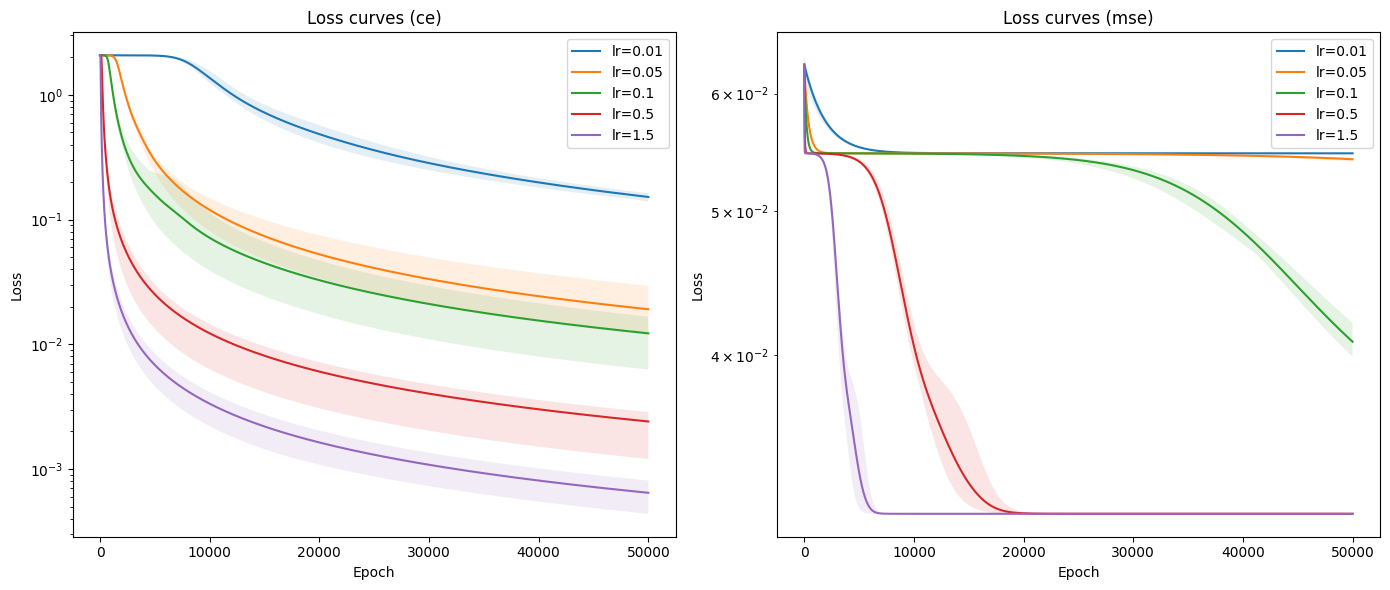

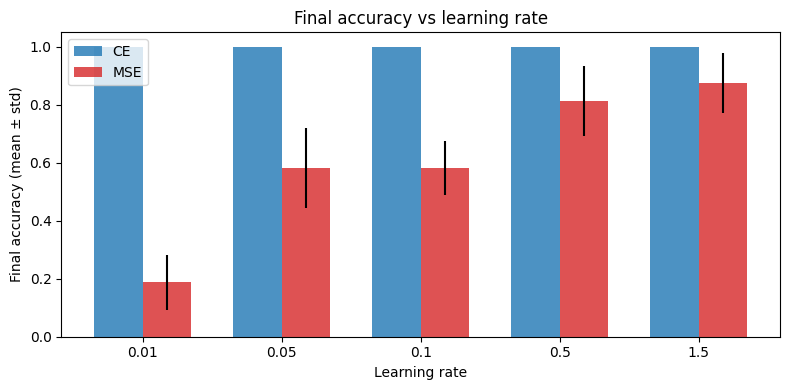

Learning rate | CE mean ± std | MSE mean ± std
      0.01 | 1.000 ± 0.000 | 0.188 ± 0.095
      0.05 | 1.000 ± 0.000 | 0.583 ± 0.138
       0.1 | 1.000 ± 0.000 | 0.583 ± 0.093
       0.5 | 1.000 ± 0.000 | 0.812 ± 0.120
       1.5 | 1.000 ± 0.000 | 0.875 ± 0.102


In [18]:
# example where the lr is diffrent and we compare both losses
lrs = [0.01, 0.05, 0.1, 0.5, 1.5]
res = lr_experiment(lrs, losses=('ce','mse'), n_trials=6, n_epochs=50_000, batch_size=8)

# Plot mean loss curves for each lr (Cross-Entropy and MSE separately)
plt.figure(figsize=(14,6))
for i, loss_name in enumerate(res.keys()):
    plt.subplot(1,2,i+1)
    plt.title(f"Loss curves ({loss_name})")
    for lr, hist_block in zip(res[loss_name]['lrs'], res[loss_name]['histories']):
        mean_curve = hist_block.mean(axis=0)
        plt.plot(mean_curve, label=f"lr={lr}")
        plt.fill_between(range(len(mean_curve)),
                         hist_block.min(axis=0), hist_block.max(axis=0), alpha=0.12)
    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
plt.tight_layout()
plt.show()

# Plot final accuracy vs learning rate
plt.figure(figsize=(8,4))
width = 0.35
xpos = np.arange(len(lrs))
ce_means = [res['ce']['final_accs'][i].mean() for i in range(len(lrs))]
ce_stds  = [res['ce']['final_accs'][i].std()  for i in range(len(lrs))]
mse_means = [res['mse']['final_accs'][i].mean() for i in range(len(lrs))]
mse_stds  = [res['mse']['final_accs'][i].std()  for i in range(len(lrs))]

plt.bar(xpos - width/2, ce_means, width, yerr=ce_stds, label='CE', color='tab:blue', alpha=0.8)
plt.bar(xpos + width/2, mse_means, width, yerr=mse_stds, label='MSE', color='tab:red', alpha=0.8)
plt.xticks(xpos, [str(l) for l in lrs])
plt.ylim(0,1.05)
plt.ylabel('Final accuracy (mean ± std)')
plt.xlabel('Learning rate')
plt.title('Final accuracy vs learning rate')
plt.legend()
plt.tight_layout()
plt.show()

# Print numeric summary
print("Learning rate | CE mean ± std | MSE mean ± std")
for i, lr in enumerate(lrs):
    print(f"{lr:>10} | {ce_means[i]:.3f} ± {ce_stds[i]:.3f} | {mse_means[i]:.3f} ± {mse_stds[i]:.3f}")

#### Experiment 4: Batch size

batch_size = 1 loss = 0.6908866811357789
batch_size = 2 loss = 0.6137928788386737
batch_size = 3 loss = 0.6081520001796478
batch_size = 4 loss = 0.6039034602301891
batch_size = 5 loss = 0.6041929016851029
batch_size = 6 loss = 0.6043728711850798
batch_size = 7 loss = 0.6072438644192847
batch_size = 8 loss = 0.601915867486847


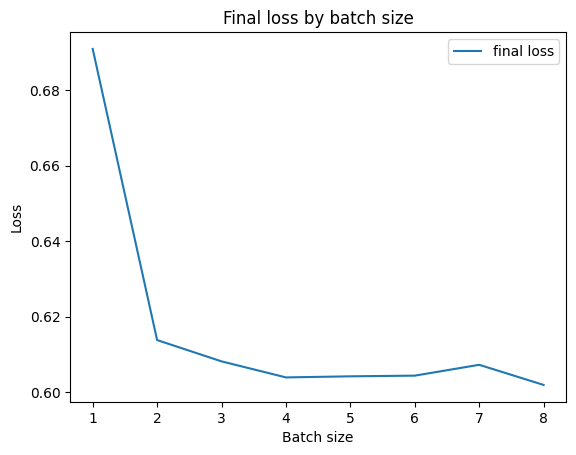

In [19]:
# Same initialization for all runs 
model_template = nn.model.Model([
    nn.layer.Layer(8, 3, nn.activation.sigmoid, std=1),
    nn.layer.Layer(3, 8, std=1),
])

loss_by_batch_size = []
for batch_size in range(1, 9):
    model = deepcopy(model_template)
    model.fit(
        x, 
        y, 
        n_epochs=200_000, 
        batch_size=batch_size, 
        lr=0.01, 
        reg_coeff=0.01,
        loss_fn=nn.loss.cross_entropy_from_logits,
        verbose=False
    )
    # plt.plot(model.history["epoch_loss"], alpha=0.7, label=f"b={batch_size}")
    
    final_loss = model.history["epoch_loss"][-1]
    loss_by_batch_size.append(final_loss)
    print("batch_size =", batch_size, "loss =", final_loss)

plt.title("Final loss by batch size")
plt.xlabel("Batch size")
plt.ylabel("Loss")
plt.plot(range(1, 9), loss_by_batch_size, label="final loss")
plt.legend();
# plt.savefig("final_loss_by_batch_size.png", dpi=200)

/Users/janikeuskirchen/Code/Maastricht/acml-assignment-1/nn/activation/sigmoid.py:7: RuntimeWarning: overflow encountered in exp
  return np.divide(1, 1+np.exp(-x))


batch_size = 1 loss = 0.005515579432976956
batch_size = 2 loss = 0.01134344726115705
batch_size = 3 loss = 0.014098757941578131
batch_size = 4 loss = 0.024180832657908432
batch_size = 5 loss = 0.024193377175657248
batch_size = 6 loss = 0.025203783569002058
batch_size = 7 loss = 0.027060965947884548
batch_size = 8 loss = 0.05099155991586661
batch_size = 1 loss = 0.00035431247070716885
batch_size = 2 loss = 0.0009000539555251254
batch_size = 3 loss = 0.0013689007175067516
batch_size = 4 loss = 0.002149357122984079
batch_size = 5 loss = 0.0019328197877020207
batch_size = 6 loss = 0.0019077938248032939
batch_size = 7 loss = 0.0018694737886353894
batch_size = 8 loss = 0.0041724519032962926
batch_size = 1 loss = 0.8069840350589033
batch_size = 2 loss = 0.7410430448874286
batch_size = 3 loss = 0.739405049081598
batch_size = 4 loss = 0.7267341353080183
batch_size = 5 loss = 0.7272083955093989
batch_size = 6 loss = 0.7253414989678569
batch_size = 7 loss = 0.7345454397367419
batch_size = 8 loss 

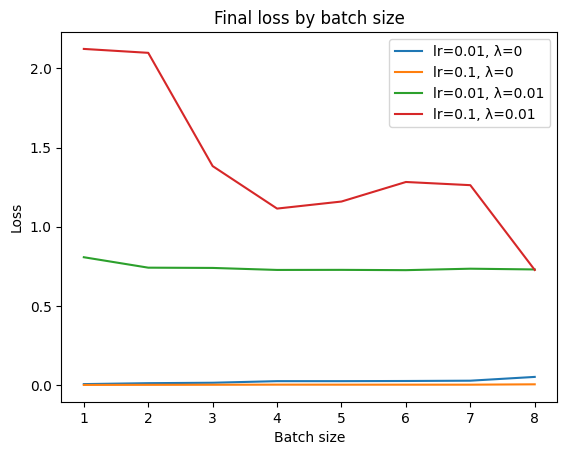

In [20]:
plt.title("Final loss by batch size")
plt.xlabel("Batch size")
plt.ylabel("Loss")

# Same initialization for all runs 
model_template = nn.model.Model([
    nn.layer.Layer(8, 3, nn.activation.sigmoid, std=1),
    nn.layer.Layer(3, 8, std=1),
])


for reg_coeff in [0, 0.01]:
    for lr in [0.01, 0.1]:
        loss_by_batch_size = []
        for batch_size in range(1, 9):
            model = deepcopy(model_template)
            model.fit(
                x, 
                y, 
                n_epochs=200_000, 
                batch_size=batch_size, 
                lr=lr, 
                reg_coeff=reg_coeff,
                loss_fn=nn.loss.cross_entropy_from_logits,
                verbose=False
            )
            # plt.plot(model.history["epoch_loss"], alpha=0.7, label=f"b={batch_size}")
            final_loss = model.history["epoch_loss"][-1]
            loss_by_batch_size.append(final_loss)
            print("batch_size =", batch_size, "loss =", final_loss)
        plt.plot(range(1, 9), loss_by_batch_size, label=f"lr={lr}, λ={reg_coeff}")

plt.legend();
# plt.savefig("final_loss_by_batch_size.png", dpi=200)

Now the same thing, but let's do multiple runs per batch size: 

batch_size = 1 loss = 0.7858413159158426
batch_size = 1 loss = 0.7006600655095809
batch_size = 1 loss = 0.608157460908859
batch_size = 1 loss = 0.8047973812961404
batch_size = 1 loss = 0.6380530506807204
batch_size = 2 loss = 0.7470688768084711
batch_size = 2 loss = 0.6737545968511209
batch_size = 2 loss = 0.5745054913059995
batch_size = 2 loss = 0.7866434541497026
batch_size = 2 loss = 0.5977462836634253
batch_size = 3 loss = 0.7427007728412776
batch_size = 3 loss = 0.6720735688788957
batch_size = 3 loss = 0.5728823412900088
batch_size = 3 loss = 0.7753739558901581
batch_size = 3 loss = 0.5919409517165461
batch_size = 4 loss = 0.7390522693119093
batch_size = 4 loss = 0.6594097555071867
batch_size = 4 loss = 0.5723479381700058
batch_size = 4 loss = 0.7688472546718086
batch_size = 4 loss = 0.5910722521778273
batch_size = 5 loss = 0.739003826653669
batch_size = 5 loss = 0.6602092539723874
batch_size = 5 loss = 0.5721280223132723
batch_size = 5 loss = 0.7685281772558361
batch_size = 5 los

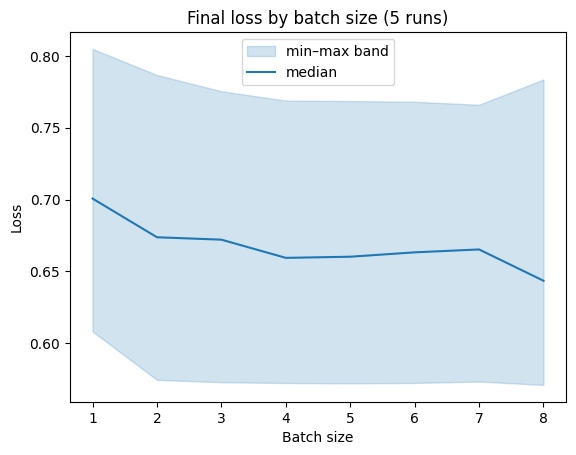

In [21]:
# Same N initializations across all batch sizes
model_templates = {}
for i in range(5):
    model_templates[i] = nn.model.Model([
        nn.layer.Layer(8, 3, nn.activation.sigmoid, std=1),
        nn.layer.Layer(3, 8, std=1),
    ])

loss_by_batch_size = []
for batch_size in range(1, 9):
    loss_this_batch_size = []
    for i in range(5):
        model = deepcopy(model_templates[i]) # i-th run is always same initialization across all batch sizes
        model.fit(
            x, 
            y, 
            n_epochs=100_000, 
            batch_size=batch_size, 
            lr=0.01, 
            reg_coeff=0.01,
            loss_fn=nn.loss.cross_entropy_from_logits,
            verbose=False
        )
        final_loss = model.history["epoch_loss"][-1]
        loss_this_batch_size.append(final_loss)
        print("batch_size =", batch_size, "loss =", final_loss)
    loss_by_batch_size.append(loss_this_batch_size)

loss_by_batch_size = np.array(loss_by_batch_size)

median = np.median(loss_by_batch_size, axis=1)
_min = loss_by_batch_size.min(axis=1)
_max = loss_by_batch_size.max(axis=1)
# p10 = np.percentile(loss_by_batch_size, 10, axis=1)
# p90 = np.percentile(loss_by_batch_size, 90, axis=1)

plt.title("Final loss by batch size (5 runs)")
plt.xlabel("Batch size")
plt.ylabel("Loss")
# plt.fill_between(range(1, 9), p10, p90, color='tab:blue', alpha=0.2, label="10–90 percentile band")
plt.fill_between(range(1, 9), _min, _max, color='tab:blue', alpha=0.2, label="min–max band")
plt.plot(range(1, 9), median, label="median")
plt.legend();
# plt.savefig("final_loss_by_batch_size_averaged.png", dpi=200) 

### Interpretation

In [22]:
model = best_model

#### Interpretation of activations

Intermediate representation

In [23]:
a = model.layers[0](x)
a.round(0)

array([[1., 0., 0.],
       [0., 1., 1.],
       [0., 0., 0.],
       [1., 1., 0.],
       [0., 1., 0.],
       [1., 0., 1.],
       [1., 1., 1.],
       [0., 0., 1.]])

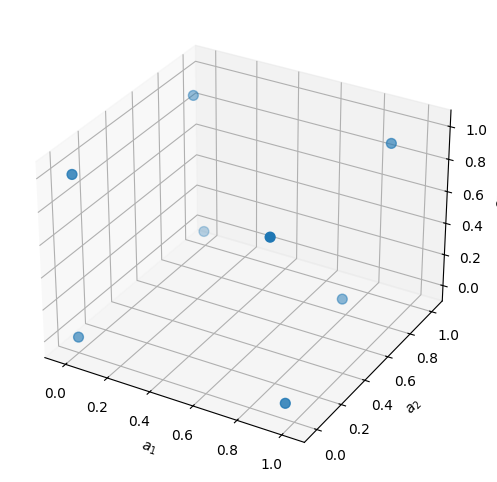

In [24]:
# Each class is assigned a point in latent space, nicely spaced from all other classes 
# Sometimes, it's the 8 corners of the cube! which I assume corresponds to the global minimum.
# But often, it finds a local minimum that seems to work, and yields a low cost, but it might pack three classes
# onto one axis, and leave one corner of the cube unused, or even put them somewhere inside the cube 
# and sometimes it ends up using only the corners, but two or more classes collapse onto a single corner
# thereby no longer allowing the next layer to distinguish those inputs 

# The input vectors, e.g. [1, 0, 0, 0, 0, 0, 0, 0], are also the 8D coordinates of a subset of corners of the 8D hypercube 
# (only those corners that are located on an axis -> axis-aligned corners, not including the origin)

# An alternative, non-geometric interpretation is that we have 8 numbers that we want to encode in binary,
# so we count from 000 through 111

# E.g. idealized:
# i=0 -> x=[1 0 0 0 0 0 0 0] -> [0 0 0]
# i=1 -> x=[0 1 0 0 0 0 0 0] -> [0 0 1]
# i=2 -> x=[0 0 1 0 0 0 0 0] -> [0 1 0]
# i=3 -> x=[0 0 0 1 0 0 0 0] -> [0 1 1]
# i=4 -> x=[0 0 0 0 1 0 0 0] -> [1 0 0]
# i=5 -> x=[0 0 0 0 0 1 0 0] -> [1 0 1]
# i=6 -> x=[0 0 0 0 0 0 1 0] -> [1 1 0]
# i=7 -> x=[0 0 0 0 0 0 0 1] -> [1 1 1]

plot_latent_space(model.layers[0](x))

Which inputs cause each of the individual hidden units to fire?

In [25]:
latents = model.layers[0](x).round(0)

print(np.where(latents[:,0]==1)[0])  # examples that activate hidden unit 0
print(np.where(latents[:,1]==1)[0])  # examples that activate hidden unit 1
print(np.where(latents[:,2]==1)[0])  # examples that activate hidden unit 2

[0 3 5 6]
[1 3 4 6]
[1 5 6 7]


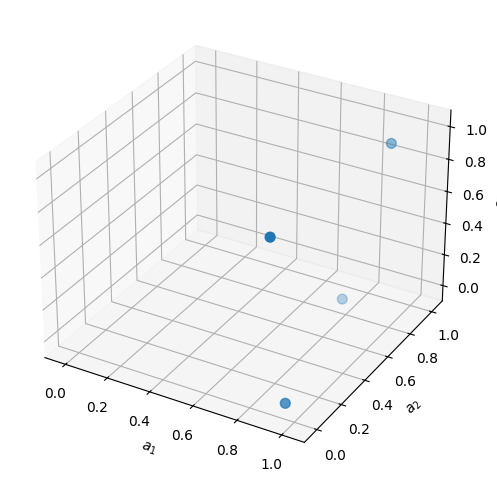

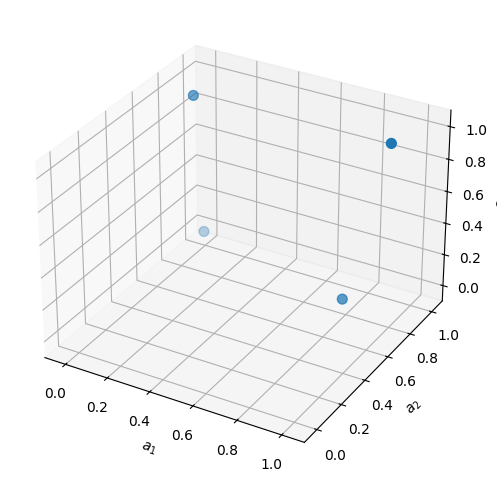

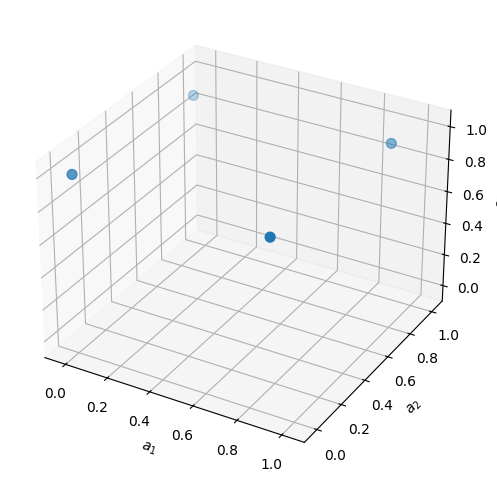

In [26]:
x_that_activate_unit_0 = nn.util.one_hot(np.where(latents[:,0]==1)[0], n_classes=8)
plot_latent_space(model.layers[0](x_that_activate_unit_0))

x_that_activate_unit_1 = nn.util.one_hot(np.where(latents[:,1]==1)[0], n_classes=8)
plot_latent_space(model.layers[0](x_that_activate_unit_1))

x_that_activate_unit_2 = nn.util.one_hot(np.where(latents[:,2]==1)[0], n_classes=8)
plot_latent_space(model.layers[0](x_that_activate_unit_2))

In [27]:
# Each hidden unit's activation corresponds to one of the faces of the cube!
# The values of all three hidden units constrains the example to the overlap between three faces 
# and thereby to an individual corner of the cube 

Output (reconstruction of the input)

In [28]:
nn.util.softmax(model(x), temperature=0.1).round(0)

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.]])

#### Interpretation of weights

**Encoder:** input to intermediate representation 

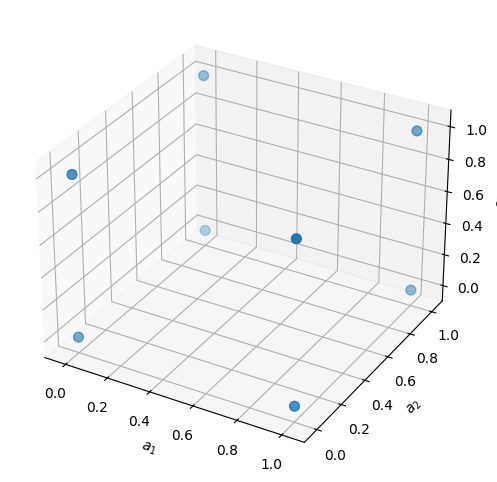

In [29]:
# Given the interpretation of the activations, this must correspond to a projection from a one-hot vector
# to a corresponding cube corner as 3D coordinates

# For a class index i (=1,...,8), which corner of the cube does it project to, and how? 

# If this were a binary circuit, this would be an 8-to-3 encoder circuit 
# (and the second layer a 3-to-8 decoder)

# The idealized weight matrix (assuming a linear transform) would be the following 3x8 matrix:
# Since the inputs are one-hot, we simply assign each input a column in this weight matrix 

w_enc = np.array([
    [0, 0, 0, 0, 1, 1, 1, 1],
    [0, 0, 1, 1, 0, 0, 1, 1],
    [0, 1, 0, 1, 0, 1, 0, 1],
])

# And if there is a bias, the input becomes a 9-vector, but we can just ignore the first entry,
# i.e. set all biases to 0. Then we have this 3x9 matrix: 
np.array([
    [0, 0, 0, 0, 0, 1, 1, 1, 1],
    [0, 0, 0, 1, 1, 0, 0, 1, 1],
    [0, 0, 1, 0, 1, 0, 1, 0, 1],
])
# but since the bias doesn't matter, I will use the 3x8 matrix instead, since it's easier 

a_ideal = (w_enc @ x).T # or: x @ w_enc.T 

plot_latent_space(a_ideal)

In [30]:
# If we also apply sigmoid, the idealized matrix uses -z instead of 0, and z instead of 1, where z is some large number
# so that sigmoid(-z)≈0 and sigmoid(z)≈1 
# Let's replace all 0 by -1, and then scale the matrix by some constant c

w_enc2 = np.array([
    [-1, -1, -1, -1,  1,  1,  1, 1],
    [-1, -1,  1,  1, -1, -1,  1, 1],
    [-1,  1, -1,  1, -1,  1, -1, 1],
])

c = 10.0

nn.activation.sigmoid(c * w_enc2).round(0)

array([[0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 1., 1., 0., 0., 1., 1.],
       [0., 1., 0., 1., 0., 1., 0., 1.]])

In [31]:
# So, how close is the learned weight matrix to this idealized weight matrix?

w0 = model.layers[0].params[1:,:].T # ignoring bias
w0

array([[ 43.42761014, -47.16967091, -48.64173778,  41.56877545,
        -65.56573461,  42.33720231,  42.67893788, -42.5840562 ],
       [-77.45825827,  38.45279792, -43.00846141,  37.42431677,
         40.62739068, -40.03559071,  38.80076088, -32.43470656],
       [-37.35616826,  34.37185991, -14.37270983, -73.44617394,
        -58.84595926,  35.20436769,  34.47909601,  51.89016869]])

In [32]:
# Since it uses a sigmoid activation, which maps it to 1 anyway, the model might want to
# make the pre-activation as as positive as possible when it's supposed to be 1, and 
# as negative as possible when it's supposed to be 0 
# If we clip it to (-1, 1) and round it, this should ideally look like the idealized weight matrix containing -1 and 1
# (the columns might be in a different order, since it might end up mapping classes to different
# cube corners than in the idealized "binary counting" way): 
w0.clip(-1, 1).round(0)

array([[ 1., -1., -1.,  1., -1.,  1.,  1., -1.],
       [-1.,  1., -1.,  1.,  1., -1.,  1., -1.],
       [-1.,  1., -1., -1., -1.,  1.,  1.,  1.]])

In [33]:
# Very close. The columns are in a different order, but this order is arbitrary anyway
# (which class the model happens to map to which corner of the cube)
# (and visible in the latent space 3D scatter plot)
w_enc2

array([[-1, -1, -1, -1,  1,  1,  1,  1],
       [-1, -1,  1,  1, -1, -1,  1,  1],
       [-1,  1, -1,  1, -1,  1, -1,  1]])

**Decoder:** intermediate representation to class logits 

In [34]:
# Given the interpretation of the activations, this must correspond to the inverse of layer 1, i.e. a projection
# back from the 3D coordinates of a corner of the cube to a one-hot vector 

# In circuit-terms, this is a 3-to-8 decoder

# the ideal decoder matrix is just the tranpose of the encoder matrix! 
w_enc2.T

array([[-1, -1, -1],
       [-1, -1,  1],
       [-1,  1, -1],
       [-1,  1,  1],
       [ 1, -1, -1],
       [ 1, -1,  1],
       [ 1,  1, -1],
       [ 1,  1,  1]])

In [35]:
# If we use the idealized weight matrix, followed by its transpose, 
# and apply softmax (with low temperature), we get the identity matrix 
# recovering the original data 

nn.util.softmax(w_enc2.T @ w_enc2, temperature=0.1).round(0)

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.]])

In [36]:
# So, how close is the learned weight matrix to this idealized weight matrix?

w1 = model.layers[1].params[1:,:].T # ignoring bias
w1

array([[ 7.92194277, -6.77914667, -5.56217037],
       [-6.28011776,  5.64541041,  5.1191606 ],
       [-4.56753103, -4.28171228, -4.26154918],
       [ 4.65018969,  4.69891147, -6.54580715],
       [-6.84771807,  7.91926076, -6.287166  ],
       [ 5.72156907, -6.19684881,  5.44106347],
       [ 4.92059427,  4.74590213,  4.33629293],
       [-5.6177364 , -5.38712956,  8.0215783 ]])

In [37]:
# How close is it to the transpose of the actually learned encoder weight matrix, w0?
print(w1.clip(-1, 1).round(0))
print()
print((w0.clip(-1, 1)).round(0).T)

[[ 1. -1. -1.]
 [-1.  1.  1.]
 [-1. -1. -1.]
 [ 1.  1. -1.]
 [-1.  1. -1.]
 [ 1. -1.  1.]
 [ 1.  1.  1.]
 [-1. -1.  1.]]

[[ 1. -1. -1.]
 [-1.  1.  1.]
 [-1. -1. -1.]
 [ 1.  1. -1.]
 [-1.  1. -1.]
 [ 1. -1.  1.]
 [ 1.  1.  1.]
 [-1. -1.  1.]]
